In [1]:
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from tqdm.notebook import tqdm
from helpers import *
from matplotlib.cm import ScalarMappable
from joblib import Parallel, delayed, parallel_backend
import multiprocessing
%matplotlib inline

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
b0, data1 = parse('20060504_072852_NOAA_12.m.pro')
data1 = data1.astype(float)
data1[data1 < 0] = -1000

In [3]:
b0, data2 = parse('20060504_125118_NOAA_17.m.pro')
data2 = data2.astype(float)
data2[data2 < 0] = -1000

In [4]:
point_coors = []
for x in range(365, 1112, 40):
    for y in range(539, 1101, 40):
        point_coors.append([y, x])
wind_size = (31, 31)
vicinity_size = (100, 100)

In [5]:
data1 = torch.tensor(data1).cuda()
data2 = torch.tensor(data2).cuda()

In [6]:
%%time
new_coors = []
scores = []

imgs = None

for point_coor in tqdm(point_coors):
    idx, score = find_best_match_cuda(data1, data2, point_coor, 
                                      wind_size, vicinity_size, ssim_cuda, 
                                      mode='max')
    new_coors.append(idx)
    scores.append(score)

new_coors = np.array(new_coors)
point_coors = np.array(point_coors)
scores = np.array(scores)

data1 = data1.cpu().numpy()
data2 = data2.cpu().numpy()

  0%|          | 0/285 [00:00<?, ?it/s]

Wall time: 1min 27s


In [7]:
gv_idx = scores>0.5

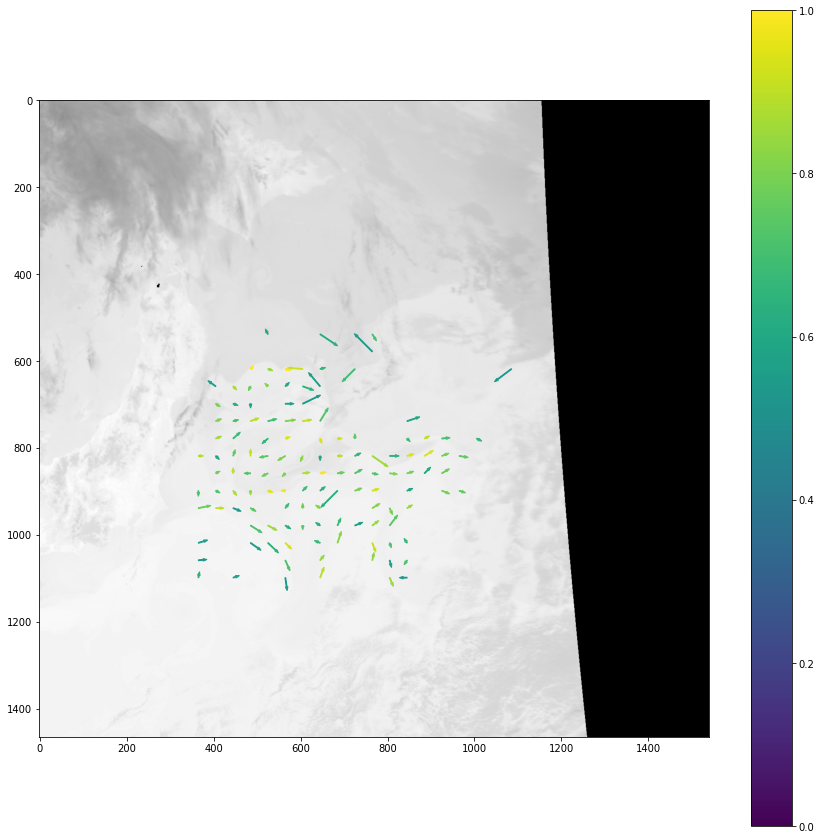

In [8]:
colors = ScalarMappable(cmap='viridis').to_rgba(scores)

fig = plt.figure(figsize=(15, 15))
plt.imshow(data1, cmap='gray')
for x1, y1, x2, y2, color in zip(point_coors[:, 1][gv_idx], point_coors[:, 0][gv_idx], 
                                 new_coors[:, 1][gv_idx], new_coors[:, 0][gv_idx], colors[gv_idx]):
    plt.arrow(x1, y1, x2-x1, y2-y1, width=2, head_width=6, color=color)

fig.colorbar(ScalarMappable(cmap='viridis'))
plt.show()